# ロジスティック回帰

ロジスティック回帰の例として，学生がある大学に入学できるかを2つの試験の点数から予測する問題を扱う．過去の出願者に対する2つの試験の点数と入学許可の有無を訓練データとして用いる．

## データのロード

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [2]:
# 訓練データのロード
# 1列目：試験1の点数，2列目：試験2の点数，3列目：入学許可の有無（合格が1，不合格が0）
data = np.loadtxt('data/ex2data1.txt',delimiter=',')
X_unext = np.array(data[:,0:-1]) # 特徴量を各出願者について縦に並べた行列
y = np.array(data[:,-1]).reshape(-1,1) # ターゲットを各出願者について縦に並べた列ベクトル
m, n = X_unext.shape
print('訓練データの数：m =',m)
print('特徴量の数：n =',n)

訓練データの数：m = 100
特徴量の数：n = 2


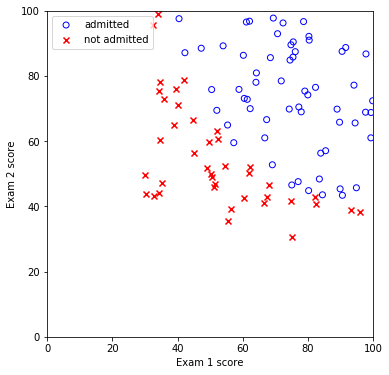

In [3]:
# 訓練データのプロット
i_y1 = (y == 1).flatten() # 合格者の論理インデックス
i_y0 = (y == 0).flatten() # 不合格者の論理インデックス
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(X_unext[i_y1,0],X_unext[i_y1,1],marker='o',facecolors='none', edgecolors='b',label='admitted')
ax.scatter(X_unext[i_y0,0],X_unext[i_y0,1],marker='x',color='r',label='not admitted')
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Exam 1 score')
ax.set_ylabel('Exam 2 score')
ax.legend()
ax.set_aspect('equal')

## 仮設とコスト関数の定義

特徴量ベクトルを$x=(x_0 ,x_1 ,\dots ,x_n)^\mathrm{T}$，ターゲットを$y$とする．ただし，0番目の特徴量は常に$x_0 =1$とする．特徴量とターゲットの組$(x,y)$は何らかの真の分布$p(x,y)=p(x)p(y\vert x)$に従う．特徴量$x$が与えられたときのターゲット$y$の分布$p(y\vert x)$を推定したい．ロジスティック回帰では，パラメータを$\theta =(\theta _0 ,\theta _1 ,\dots ,\theta _n)^\mathrm{T}$に対して仮設
$$
h_\theta (x)=\sigma (x^\mathrm{T} \theta ),\quad\sigma (z)=\frac{1}{1+e^{-z}}
$$
を，特徴量が与えられたときのターゲットの確率分布$p(y\vert x,\theta )$と解釈する．

コスト関数はターゲットの真の分布（すなわち訓練データのターゲットが$y$に等しいとき1，そうでないとき0となる分布）と仮設の交差エントロピーとする：
$$
J(\theta )=-\frac{1}{m} \sum _{d=1}^m [y^{(d)} \log h_\theta (x^{(d)})+(1-y^{(d)})\log (1-h_\theta (x^{(d)}))].
$$
ただし，$(d)$は$d=1,\dots ,m$番目のデータを表す．このとき，コスト関数の勾配は次のように表される：
$$
\frac{\partial J(\theta )}{\partial\theta} =\frac{1}{m} \sum _{d=1}^m (h_\theta (x^{(d)})-y^{(d)})x^{(d)} .
$$

In [4]:
# 新たな特徴量1を追加する関数
# X_unextは追加前のm*n行列，Xは追加後のm*(n+1)行列
def add1column(X_unext):
    X = np.hstack((np.ones((X_unext.shape[0],1)), X_unext))
    return(X)

In [5]:
# 特徴量行列
X = add1column(X_unext)

In [6]:
# シグモイド関数
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return(s)

In [7]:
# コスト関数と勾配
def costFunction(X,y,theta):
    epsilon = 1e-7
    m = y.size
    h = sigmoid(np.dot(X,theta))
    J = -1 / m * (np.dot(y.T,np.log(h+epsilon)) + np.dot((1-y).T,np.log(1-h+epsilon)))
    J_theta = 1 / m * np.dot(X.T,h-y)
    return(J,J_theta)

In [8]:
# 初期パラメータでコスト関数を評価
thetai = np.zeros((n+1,1)) # 初期パラメータ（ゼロベクトル）
costFunction(X,y,thetai) # コストとその勾配

(array([[0.69314698]]), array([[ -0.1       ],
        [-12.00921659],
        [-11.26284221]]))

## 勾配法

勾配法の更新式は次のように与えられる：
$$
\theta\leftarrow\theta -\alpha\frac{\partial J(\theta )}{\partial\theta} =\theta -\alpha\frac{1}{m} \sum _{d=1}^m (h_\theta (x^{(d)})-y^{(d)})x^{(d)} .
$$

In [9]:
# 勾配法
def gradientDescent(X,y,thetai,alpha=1e-4,num_iters=20000):
    m = y.size
    theta = thetai
    theta_history = thetai * np.ones(num_iters)
    J_history = np.zeros(num_iters)
    
    _, J_theta = costFunction(X,y,theta)
    for i in np.arange(num_iters):
        theta = theta - alpha * J_theta
        theta_history[:,[i]] = theta
        J_history[i], J_theta = costFunction(X,y,theta)
    
    return(theta,theta_history,J_history)

勾配法実行後のパラメータ theta = [-0.13838573  0.0113862   0.00152735]


Text(0.5, 0, '$\\theta _2$')

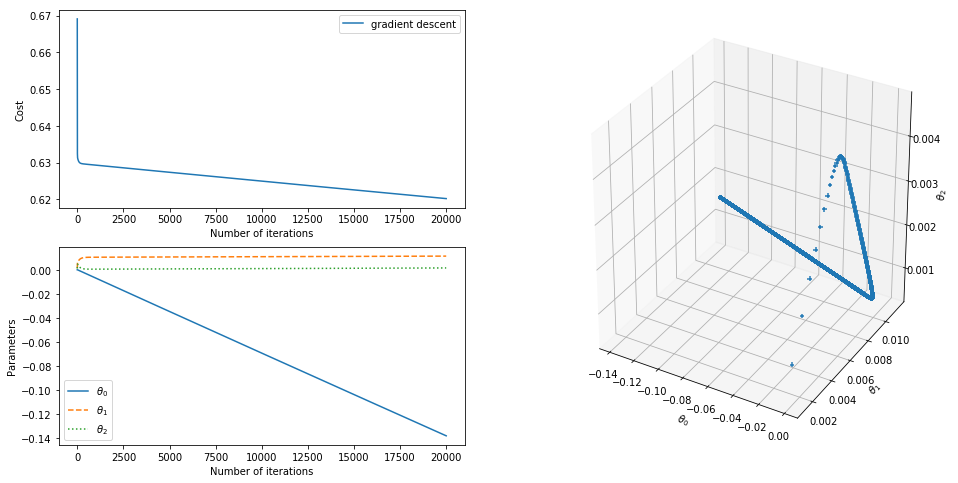

In [10]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X,y,thetai)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history,label='gradient descent')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

## 自然勾配法

自然勾配法の更新式は次のように与えられる：
$$
\theta\leftarrow\theta -\alpha g^{-1} \frac{\partial J(\theta )}{\partial\theta} =\theta -\alpha\left(\sum _{d=1}^m h_\theta (x^{(d)})(1-h_\theta (x^{(d)}))x_i^{(d)} x_j^{(d)} \right) ^{-1} \sum _{d=1}^m (h_\theta (x^{(d)})-y^{(d)})x^{(d)} .
$$
ここで，
$$
g_{ij} (\theta )=\frac{1}{m} \sum _{d=1}^m h_\theta (x^{(d)})(1-h_\theta (x^{(d)}))x_i^{(d)} x_j^{(d)}
$$
を成分に持つ行列$g=(g_{ij})$はFisher情報行列である．

In [11]:
# コスト関数と自然勾配
def costFunction_natural(X,y,theta):
    epsilon = 1e-7
    m = y.size
    h = sigmoid(np.dot(X,theta))
    J = -1 / m * (np.dot(y.T,np.log(h+epsilon)) + np.dot((1-y).T,np.log(1-h+epsilon)))
    XT = X.T
    h_theta = h*(1-h)
    J_theta = np.linalg.solve(np.dot(XT,h_theta*X), np.dot(XT,h-y))
    return(J,J_theta)

In [12]:
# 自然勾配法
def naturalGradientDescent(X,y,thetai,alpha=1,num_iters=10):
    m = y.size
    theta = thetai
    theta_history = thetai * np.ones(num_iters)
    J_history = np.zeros(num_iters)
    
    _, J_theta = costFunction_natural(X,y,theta)
    for i in np.arange(num_iters):
        theta = theta - alpha * J_theta
        theta_history[:,[i]] = theta
        J_history[i], J_theta = costFunction_natural(X,y,theta)
    
    return(theta,theta_history,J_history)

勾配法実行後のパラメータ theta = [-25.16133357   0.20623171   0.2014716 ]


Text(0.5, 0, '$\\theta _2$')

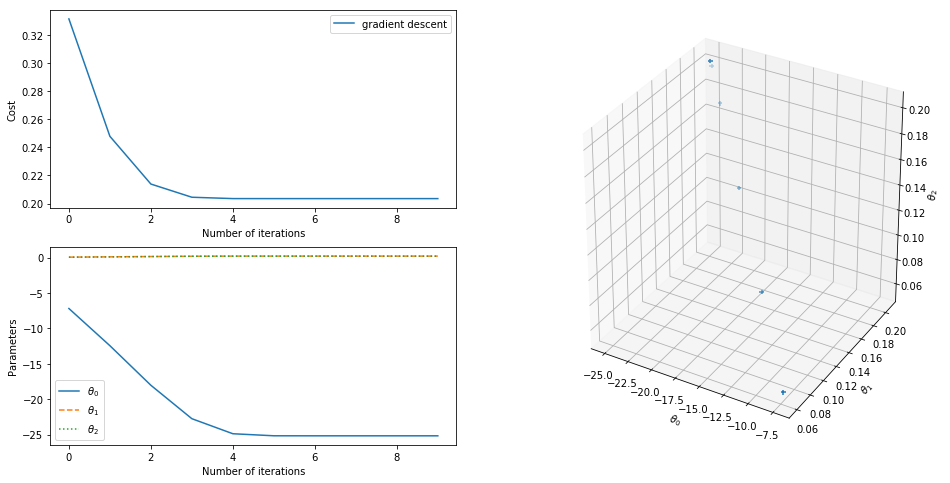

In [13]:
# 自然勾配法の実行
theta_ngd, theta_nhistory, J_nhistory = naturalGradientDescent(X,y,thetai)
print('勾配法実行後のパラメータ theta =',theta_ngd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_nhistory,label='gradient descent')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_nhistory[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_nhistory[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_nhistory[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_nhistory[0,:],theta_nhistory[1,:],theta_nhistory[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')

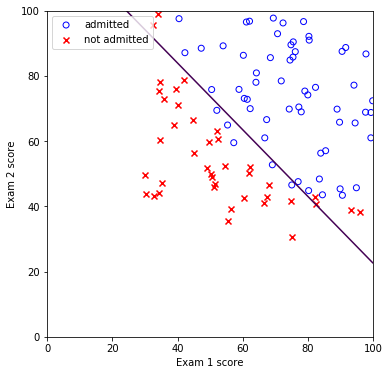

In [14]:
x1v = np.linspace(0,100)
x2v = np.linspace(0,100)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = np.zeros((x2v.size,x1v.size))
for i in np.arange(np.size(x1v)):
    for j in np.arange(np.size(x2v)):
        hg[j,i] = sigmoid(np.dot(np.array([1,x1v[i],x2v[j]]),theta_ngd))

# プロット
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(X_unext[i_y1,0],X_unext[i_y1,1],marker='o',facecolors='none', edgecolors='b',label='admitted')
ax.scatter(X_unext[i_y0,0],X_unext[i_y0,1],marker='x',color='r',label='not admitted')
ax.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Exam 1 score')
ax.set_ylabel('Exam 2 score')
ax.legend()
ax.set_aspect('equal')